In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, TensorDataset, DataLoader, Subset
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torchvision.transforms as T


import torch.nn.functional as F
from torchvision import datasets, transforms


In [2]:
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.image_classification_models import *
from models.train_test import *
from prunning_methods.LTH import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import os
os.chdir(repo_root)

In [4]:
from pathlib import Path
import re

# If you want to load the .pth files, uncomment the import below
# import torch

KNOWN_DATASETS = {
    "cifar10", "cifar100", "mnist", "kmnist", "fashion_mnist", "emnist", "stl10", "svhn"
}

def parse_filename(path):
    """
    Returns (dataset, model, run_index) from a file name like:
    LTH_<dataset>_<model>[_<run>].pth
    """
    name = path.stem  # no extension
    if not name.startswith("LTH_"):
        raise ValueError(f"Unexpected prefix in {path.name}")
    core = name[4:]  # strip "LTH_"
    parts = core.split("_")

    # Detect dataset (some have two tokens, e.g., fashion_mnist)
    if len(parts) >= 2 and f"{parts[0]}_{parts[1]}" in KNOWN_DATASETS:
        dataset = f"{parts[0]}_{parts[1]}"
        rest = parts[2:]
    else:
        dataset = parts[0]
        rest = parts[1:]

    if not rest:
        raise ValueError(f"Missing model in {path.name}")

    # Optional trailing numeric run index
    run_index = None
    if rest and re.fullmatch(r"\d+", rest[-1]):
        run_index = int(rest[-1])
        rest = rest[:-1]

    model = "_".join(rest)
    return dataset, model, run_index

In [5]:
ConvSmallDict = {"dataset": [], "remaining_params_perc": [], 'accuracy': [], "logdet_per_dim": []}
Resnet18Dict = {"dataset": [], "remaining_params_perc": [], 'accuracy': [], "layer1.0.conv1.weight": [],
            "layer1.0.conv2.weight": [],
            "layer1.1.conv1.weight": [],
            "layer1.1.conv2.weight": [],
            "layer2.0.conv1.weight": []}

DenseNetDict = {"dataset": [], "remaining_params_perc": [], 'accuracy': [], "features.0.0.weight": [],
            "features.1.0.block.0.weight": [],
            "features.1.1.block.0.weight": [],
            "features.1.2.block.0.weight": []}

ConvNextTinyDict = {"dataset": [], "remaining_params_perc": [], 'accuracy': [], "features.0.0.weight"  : [],
            "features.1.0.block.0.weight": [],
            "features.1.1.block.0.weight": [],
            "features.1.2.block.0.weight": []}

ResNet50Dict = {"dataset": [], "remaining_params_perc": [], 'accuracy': [],   "layer1.0.conv1.weight": [],
            "layer1.0.conv2.weight": [],
            "layer1.1.conv1.weight": [],
            "layer1.1.conv2.weight": [],
            "layer2.0.conv1.weight": []}

WideResNetDict = {"dataset": [], "remaining_params_perc": [], 'accuracy': [],  'conv1.weight': [],
            "layer1.0.conv1.weight": [],
            "layer1.1.conv3.weight": []}

In [6]:
def append_on_dict(output_dict, perc, ds, model_dict, model_name):
    model_dict["dataset"].append(ds)
    model_dict["remaining_params_perc"].append(perc)
    model_dict["accuracy"].append(output_dict[0])

    if model_name == 'convmodel':
        model_dict['logdet_per_dim'].append(output_dict[-1])

    else:
        for key, value in output_dict[-1].items():
            model_dict[key].append(value)

In [7]:
# ---- main loop ----
folder = Path("results/")  # <-- change this
records = []

for pth in folder.glob("*.pth"):
    ds, model, run_idx = parse_filename(pth)
    print(model, ds)
    output_dict = torch.load(pth)  
    for key, value in output_dict.items():
        if model == "convmodel":
            append_on_dict(output_dict[key][0], key, ds, ConvSmallDict, model)
        elif model == "resnet18":
            append_on_dict(output_dict[key][0], key, ds, Resnet18Dict, model)
        elif model == "densenet":
            append_on_dict(output_dict[key][0], key, ds, DenseNetDict, model)
        elif model == "convnext_tiny":
            append_on_dict(output_dict[key][0], key, ds, ConvNextTinyDict, model)
        elif model == "resnet50":
            append_on_dict(output_dict[key][0], key, ds, ResNet50Dict, model)
        elif model == "wide_resnet":
            append_on_dict(output_dict[key][0], key, ds, WideResNetDict, model)

convnext_tiny cifar100


C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_26020\1395289187.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  output_dict = torch.load(pth)


convnext_tiny cifar10
resnet18 cifar10
resnet50 cifar10
wide_resnet cifar10
convmodel emnist
convmodel fashion_mnist
convmodel kmnist
convmodel mnist
convnext_tiny stl10
resnet18 stl10
resnet18 svhn
resnet50 svhn


In [8]:
convmodel = torch.load("results/LTH_mnist_convmodel.pth")

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_26020\64446057.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  convmodel = torch.load("results/LTH_mnist_convmodel.pth")


In [9]:
convmodel[90][0][-1]

2.8775587088151866

In [10]:
import pandas as pd


df_convmodel = pd.DataFrame(ConvSmallDict)
df_resnet18 = pd.DataFrame(Resnet18Dict)
df_densenet = pd.DataFrame(DenseNetDict)
df_convnext_tiny = pd.DataFrame(ConvNextTinyDict)
df_resnet50 = pd.DataFrame(ResNet50Dict)
df_wide_resnet = pd.DataFrame(WideResNetDict)

In [11]:
df_convmodel.head()

,dataset,remaining_params_perc,accuracy,logdet_per_dim
0,emnist,100,0.877548,1.365255
1,emnist,90,0.858942,1.177934
2,emnist,80,0.844567,1.281981
3,emnist,70,0.839519,1.256989
4,emnist,60,0.820144,1.442959


In [14]:
df_wide_resnet.head()

,dataset,remaining_params_perc,accuracy,conv1.weight,layer1.0.conv1.weight,layer1.1.conv3.weight
0,cifar10,100,0.9084,1.823510,2.828557,4.253379
1,cifar10,90,0.8487,1.419015,1.409729,1.597394
2,cifar10,80,0.8315,1.383799,1.140099,1.452884
3,cifar10,70,0.8661,1.175951,1.033575,1.679967
4,cifar10,60,0.8612,1.147653,0.949859,1.595782


In [ ]:
# df_convmodel.to_csv("tables/convmodel_table.csv", index=False)
# df_resnet18.to_csv("tables/resnet18_table.csv", index=False)
# df_densenet.to_csv("tables/densenet_table.csv", index=False)
# df_convnext_tiny.to_csv("tables/convnext_tiny_table.csv", index=False)
# df_resnet50.to_csv("tables/resnet50_table.csv", index=False)
# df_wide_resnet.to_csv("tables/wide_resnet_table.csv", index=False)

In [ ]:
# df_convmodel.to_latex("tables/convmodel_table.tex", index=False)
# df_resnet18.to_latex("tables/resnet18_table.tex", index=False)
# df_densenet.to_latex("tables/densenet_table.tex", index=False)
# df_convnext_tiny.to_latex("tables/convnext_tiny_table.tex", index=False)
# df_resnet50.to_latex("tables/resnet50_table.tex", index=False)
# df_wide_resnet.to_latex("tables/wide_resnet_table.tex", index=False)

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def set_paper_style(font_size=12):
    mpl.rcParams.update({
        # Figure
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.02,

        # Fonts / text
        "font.size": font_size,
        "axes.titlesize": font_size + 1,
        "axes.labelsize": font_size,
        "legend.fontsize": font_size - 1,
        "xtick.labelsize": font_size - 1,
        "ytick.labelsize": font_size - 1,

        # Axes
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linewidth": 0.7,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.9,

        # Lines
        "lines.linewidth": 2,
        "lines.markersize": 4,

        # Ticks
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.minor.size": 2,
        "ytick.minor.size": 2,

        # Legend
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.borderpad": 0.4,
        "legend.handlelength": 1.6,
    })

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple


def _find_column(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    """Return the first column name that exists in df."""
    for c in candidates:
        if c in df.columns:
            return c
    return None


def _detect_logdet_columns(
    df: pd.DataFrame,
    dataset_col: str,
    x_col: str,
    acc_col: str,
) -> List[str]:
    """
    Heuristic: all numeric columns except (dataset, x, accuracy) are logdet curves.
    """
    excluded = {dataset_col, x_col, acc_col}
    numeric_cols = [
        c for c in df.columns
        if c not in excluded and pd.api.types.is_numeric_dtype(df[c])
    ]
    return numeric_cols


def _pretty_logdet_labels(logdet_cols: List[str]) -> Dict[str, str]:
    """
    Map each logdet column to a nice label.
    - If only one curve => "full"
    - Else => "layer1", "layer2", ... (based on column order)
    """
    if len(logdet_cols) == 1:
        return {logdet_cols[0]: "full"}

    return {col: f"layer{i+1}" for i, col in enumerate(logdet_cols)}


def plot_dataset_two_panel(
    df_dataset: pd.DataFrame,
    dataset_name: str,
    x_col: str,
    acc_col: str,
    logdet_cols: List[str],
    figsize: Tuple[int, int] = (11, 4),
    savepath: Optional[str] = None,
) -> plt.Figure:
    # ✅ style BEFORE creating the figure
    set_paper_style()

    # sort by x descending
    d = df_dataset.sort_values(x_col, ascending=False).reset_index(drop=True)

    # ✅ force x to be numeric (prevents invert bugs)
    x = pd.to_numeric(d[x_col], errors="coerce").to_numpy()

    label_map = _pretty_logdet_labels(logdet_cols)

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)

    # -------- Left: logdet curves --------
    ax0 = axes[0]
    for col in logdet_cols:
        y = pd.to_numeric(d[col], errors="coerce").to_numpy()
        ax0.plot(x, y, marker="o", label=label_map[col])

    ax0.set_title(f"{dataset_name} — logdet")
    ax0.set_xlabel("Remaining params (%)")
    ax0.set_ylabel(r"$f(H)/\mathrm{dim}$")
    ax0.grid(False)

    if len(logdet_cols) > 1:
        ax0.legend()

    # -------- Right: accuracy --------
    ax1 = axes[1]
    acc = pd.to_numeric(d[acc_col], errors="coerce").to_numpy()
    ax1.plot(x, acc, marker="o", label="accuracy")
    ax1.set_title(f"{dataset_name} — accuracy")
    ax1.set_xlabel("Remaining params (%)")
    ax1.set_ylabel("accuracy")
    ax1.grid(False)

    # ✅ ALWAYS invert x-axis by forcing limits
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    ax0.set_xlim(xmax, xmin)
    ax1.set_xlim(xmax, xmin)

    # ✅ suptitle + tight_layout without clipping
    fig.suptitle(f"{dataset_name} pruning curves")
    fig.tight_layout(rect=[0, 0, 1, 0.92])

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")

    return fig



def plot_all_datasets_two_panel(
    df: pd.DataFrame,
    dataset_col: str = "dataset",
    remaining_col_candidates: List[str] = ["remaining_params_perc", "remaining_param_percent", "remaining_params_percent"],
    acc_col_candidates: List[str] = ["accuracy", "acc"],
    invert_x: bool = True,
    figsize: Tuple[int, int] = (8,4),
    save_dir: Optional[str] = None,
) -> Dict[str, plt.Figure]:
    """
    Makes one (logdet|accuracy) side-by-side figure for each dataset in df.
    Returns dict: dataset_name -> fig
    """
    x_col = _find_column(df, remaining_col_candidates)
    if x_col is None:
        raise ValueError(f"Could not find remaining params column. Tried: {remaining_col_candidates}")

    acc_col = _find_column(df, acc_col_candidates)
    if acc_col is None:
        raise ValueError(f"Could not find accuracy column. Tried: {acc_col_candidates}")

    if dataset_col not in df.columns:
        raise ValueError(f"Missing dataset column '{dataset_col}'")

    figs: Dict[str, plt.Figure] = {}

    for dataset_name, dset_df in df.groupby(dataset_col):
        logdet_cols = _detect_logdet_columns(dset_df, dataset_col=dataset_col, x_col=x_col, acc_col=acc_col)
        if not logdet_cols:
            raise ValueError(f"No logdet columns found for dataset '{dataset_name}'")

        savepath = None
        if save_dir is not None:
            safe_name = re.sub(r"[^a-zA-Z0-9_.-]+", "_", str(dataset_name))
            savepath = f"{save_dir}/{safe_name}_two_panel.png"

        fig = plot_dataset_two_panel(
            df_dataset=dset_df,
            dataset_name=str(dataset_name),
            x_col=x_col,
            acc_col=acc_col,
            logdet_cols=logdet_cols,
            invert_x=invert_x,
            figsize=figsize,
            savepath=savepath,
        )
        figs[str(dataset_name)] = fig

    return figs


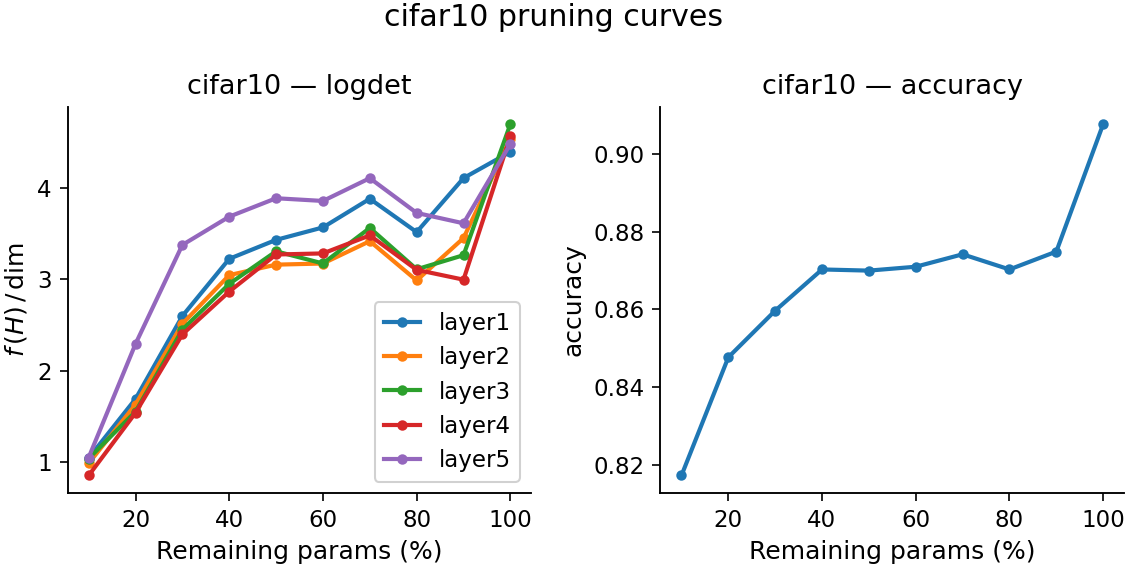

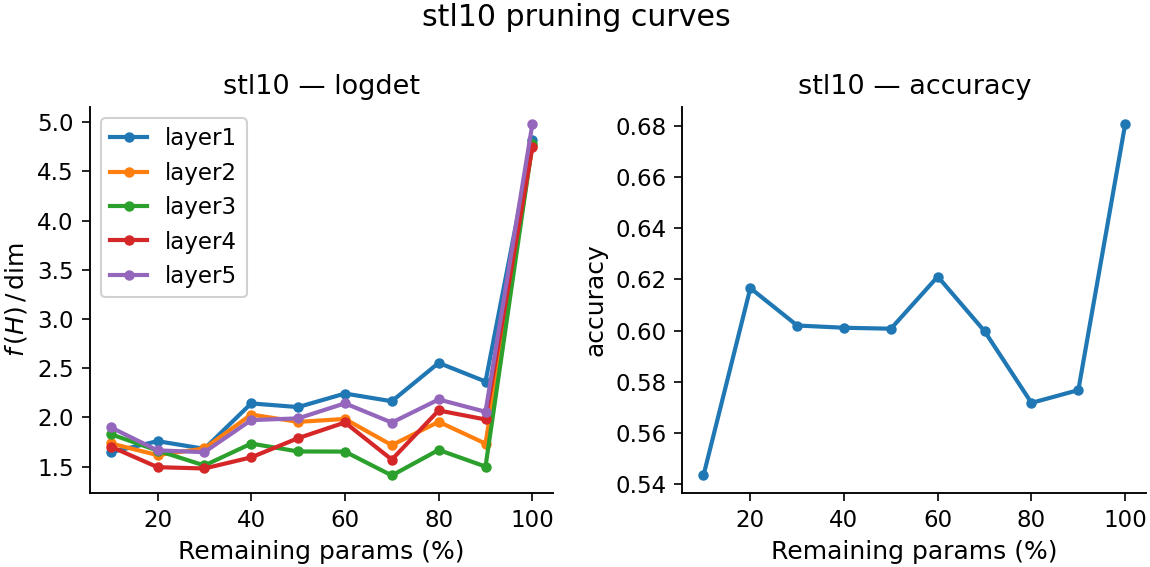

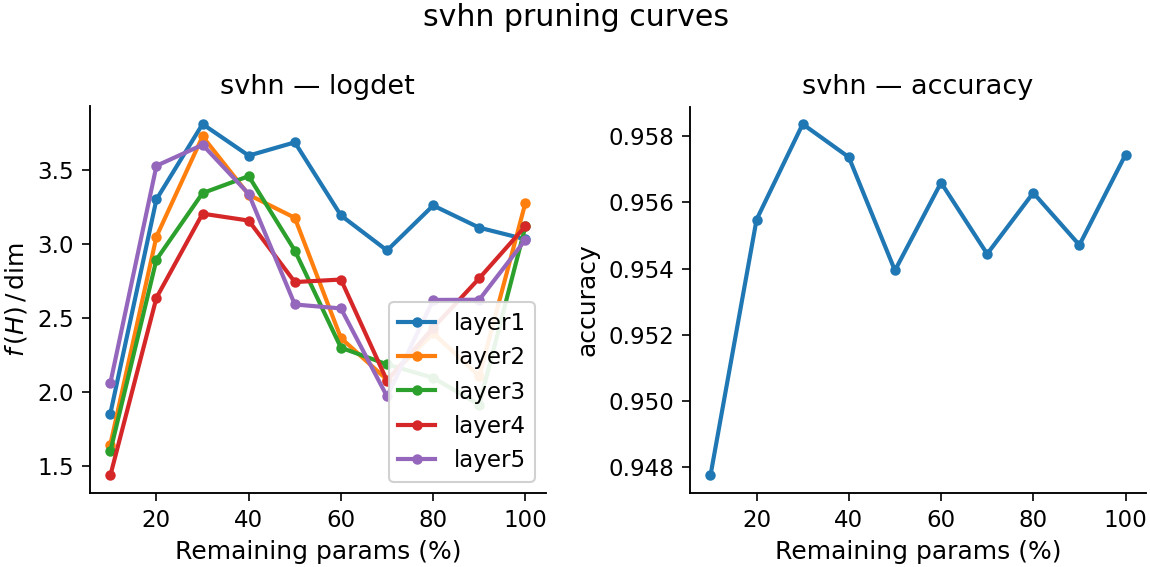

In [31]:
figs = plot_all_datasets_two_panel(df_resnet18, invert_x=True)
